# RIP.ie daily death data analysis

* http://dmnfarrell.github.io/
* https://data.gov.ie/dataset/list-of-nursing-homes-in-ireland/resource/489aad00-cad1-41d7-92bf-8b5cdd9d61ea
* https://data.gov.ie/dataset/62954fa3-1492-48af-93d1-5c9bf6a14d1e/resource/142d3b64-8f02-4ed7-bfbd-dc3e20420f3f#&r=C01885V02316&c=STATISTIC


In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pylab as plt
import matplotlib.dates as mdates
import difflib, re

pd.set_option('display.width', 150)
locator = mdates.AutoDateLocator(minticks=4, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
sns.set_style("white")
sns.set_context('talk')
pd.set_option('display.max_colwidth', 500)

In [2]:
df = pd.read_pickle('rip_dn_scrape_final.pkl')

In [6]:
def get_season(x):
    if x.month<6:
        return '%s-%s' %(x.year-1,x.year)
    else:
        return '%s-%s' %(x.year,x.year+1)

def get_data(dups=False):
    
    df = pd.read_pickle('rip_dn_scrape_processed.pkl')
    df=df.dropna(subset=['date'])
    if dups==False:
        df=df.drop_duplicates(['name','date','county'])
    print (len(df))    
    df['date'] = pd.to_datetime(df.date,format='%d/%m/%Y',errors='coerce')
    df['name'] = df.name.replace('  ',' ')
    df.index=df.index.astype('int')
    df.sort_index()
    df['year'] = df.date.dt.year.astype(int)
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.dayofyear
    df['week'] = df.date.dt.isocalendar().week
    #df['week'] = df.date.dt.strftime('%W').astype('int')
    df['year-week'] = df.date.dt.strftime('%Y-W%U')
    df['season'] = df.apply(get_season,1)
    return df

df = get_data()
df = df[df.year>=2008]

471111


## fill missing county

In [7]:
counties = ['Limerick', 'Dublin', 'Louth', 'Donegal', 'Tipperary',
       'Wicklow', 'Mayo', 'Cavan', 'Westmeath', 'Carlow', 'Leitrim',
       'Kildare', 'Kilkenny', 'Cork', 'Meath', 'Offaly', 'Wexford',
       'Roscommon', 'Galway', 'Kerry', 'Monaghan', 'Laois', 'Sligo',
       'Clare', 'Longford', 'Waterford']

def fill_county(x):    
    c=x.county
    if c not in ['',None,np.nan]:
        return c
    a = x.address.split()[-1]
    if a in counties:
        return a    
    #print(c,a)
    return ''

df.county.value_counts()
df['county']=df.apply(fill_county,1)

## remove emigrant deaths

In [8]:
cities=['England','UK','USA','London','Manchester','Liverpool','Leeds','Birmingham','Glasgow','Edinburgh',
        'New York','Boston','Pittsburgh','Philadelphia','Sydney','Melbourne','Perth']
search='|'.join(cities)
df = df[~df.address.str.contains(r"\b(%s)\b" %search)]
print (len(df))

/tmp/ipykernel_1336979/2081193448.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df.address.str.contains(r"\b(%s)\b" %search)]


430839


In [9]:
df['notice'] = df.notice.fillna('')

In [ ]:
search1='UK'
search2='Formerly of'
#df[df.notice.str.contains(r"\b(%s)\b" %(search1))]
#df[df.notice.str.contains(r"\b((?=.*%s)(?=.*%s))\b" %(search1,search2))]

## get male/female

In [10]:
female=list(pd.read_csv('female_names.csv')['name'].str.lower())
male=list(pd.read_csv('male_names.csv')['name'].str.lower())
u=[]
def check_name(x):
    """try to detect sex"""
    
    notice=str(x.notice).lower()
    mr=['son of','husband of']
    for n in mr:
        if n in notice:
            return 'M'
    fr=['wife of','daughter of']
    for n in fr:
        if n in notice:
            return 'F' 
    if 'convent' in notice or 'wife of' in notice:
        return 'F'
    kwds = ['loving','home','residence','family','parents','heartbroken',
            'son','daughter','sister','brother','remains','wife','partner']
    for n in kwds:
        if 'his '+n in notice:
            return 'M'
        elif 'her '+n in notice:
            return 'F'
    name=x['name']
    if type(name) is float:
        return
    if 'née' in name:
        return 'F'
    #print (x)
    s = name.split()
    s = [i.strip("()").strip(',').lower() for i in s]
    #print (s)
    for n in s:
        if len(n)<=1:
            continue
        if n in female:
            return 'F'
        elif n in male:
            return 'M'            
    #print (s)
    u.extend(s)
    return 'U'

df['sex'] = df.apply(check_name,1)
df.sex.value_counts()

M    218779
F    210846
U      1214
Name: sex, dtype: int64

In [11]:
df[df.sex=='U'].to_csv('unknown.csv')

## nursing homes

crude method to to find notices referring to nursing homes. may take several minutes

In [14]:
nhomes = pd.read_csv('nursing_homes.csv')
search = '|'.join(nhomes.name)
ss = r"\b(%s)\b" %search
#print (ss)

def find_nhome(x):
    if type(x.notice) is not str:
        return
    notice = x.notice.replace(',',' ')
    f =  re.findall(ss,notice)
    if len(f)>0:
        return f[0][0]    
    kwds = ['nursing home','care home','residential care']
    for k in kwds:
        if k in notice.lower():
            return 'unknown'
    
import time
st=time.time()
z=df.sample(600,random_state=4)
z['home'] = z.apply(lambda x: find_nhome(x),1)
#print (x.home)
print (len(z[~z.home.isnull()]))
print(time.time()-st)

102
0.2839171886444092


In [ ]:
z[z.home=='unknown']

In [15]:
df['home'] = df.apply(lambda x: find_nhome(x),1)

In [16]:
df.to_pickle('rip_dn_scrape_final.pkl')

# Plots

In [ ]:
sub=df[~df.home.isnull()]
X=pd.pivot_table(sub, index='month',columns='year',values='home',aggfunc='size')
f,ax=plt.subplots(1,2,figsize=(14,7))
axs=ax.flat
g=sns.heatmap(X.iloc[:,4:],cmap='coolwarm',ax=axs[0]) #annot=True,annot_kws={'fontsize':8}
f.suptitle('RIP.ie notices mentioning nursing homes, per month')
axs[0].set_title('total per month')
#print (X)
sub[(sub.date<'2022-01-01')].groupby('year').size().plot(ax=axs[1])
axs[1].set_title('trend yearly (likely reporting bias)')
plt.tight_layout()
f.savefig('nursing_home_heatmap.png')

<AxesSubplot:xlabel='season'>

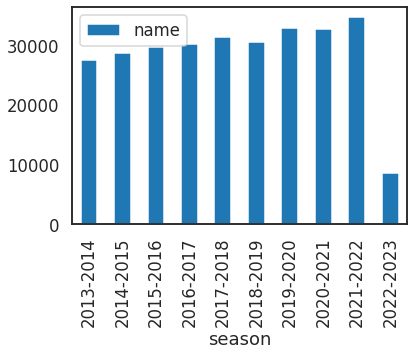

In [17]:
d = df.groupby('season').agg({'name':np.size})
d = d[6:]
d.plot(kind='bar')

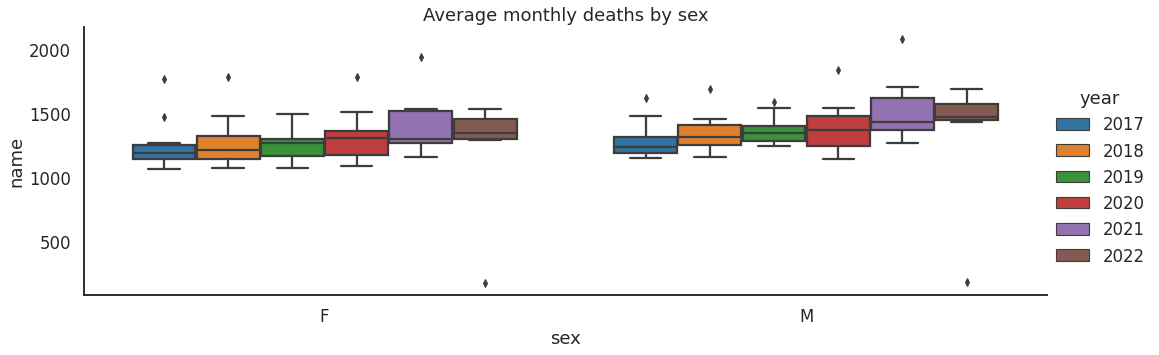

In [18]:
sub=df[df.sex!='U']
g=sub.groupby(['year','month','sex']).agg({'name':np.size}).reset_index()
g = g[(g.year>2016) & (g.year<2023)]
#print (g)
sns.catplot(data=g,x='sex',y='name',hue='year',kind='box',aspect=3.0)
plt.title('Average monthly deaths by sex')
plt.savefig('ireland_deaths_ripie_bysex.png',dpi=150)

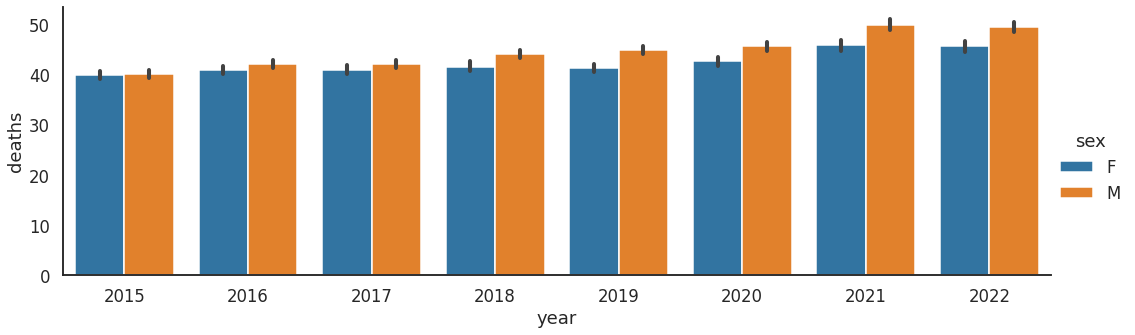

In [19]:
sub=df[df.sex!='U']
#sub=df[~df.home.isnull()]
d=pd.DataFrame(sub.groupby(['date','sex','year']).size(),columns=['deaths']).reset_index()
#d.to_csv('rip_est_deaths_daily.csv',index=False)
d = d[(d.year>2014) & (d.year<2023)]
sns.catplot(data=d,x='year',y='deaths',hue='sex',kind='bar',aspect=3.0) 

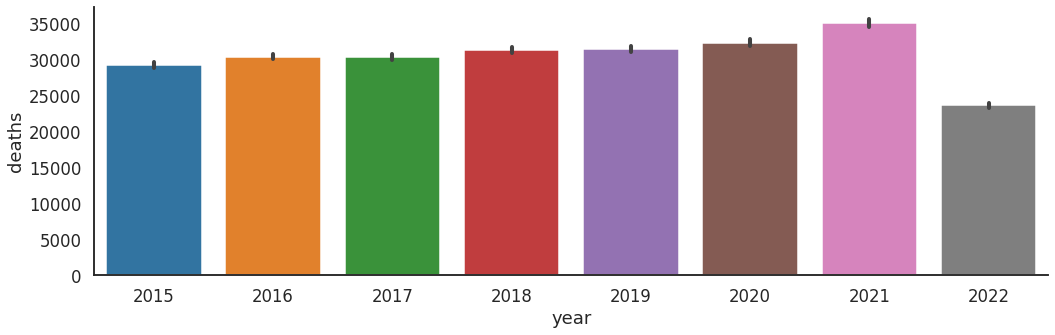

In [20]:
sns.catplot(data=d,x='year',y='deaths',kind='bar',estimator=np.sum,aspect=3.0)

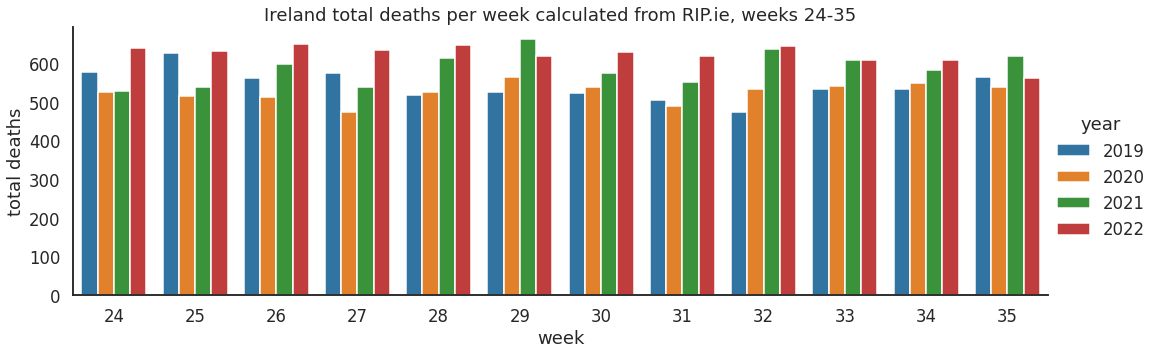

In [1162]:
#sub=df[~df.home.isnull()]
g=df.groupby(['year','week']).agg({'name':np.size}).reset_index()
g=g[(g.week>=24) & (g.week<=35)]
g = g[(g.year>2018) & (g.year<2023)]
#print (g)
sns.catplot(data=g,x='week',y='name',hue='year',kind='bar',aspect=3.0)
plt.ylabel('total deaths')
plt.title('Ireland total deaths per week calculated from RIP.ie, weeks 24-35')
plt.savefig('ireland_deaths_ripie_byweek.png',dpi=150)

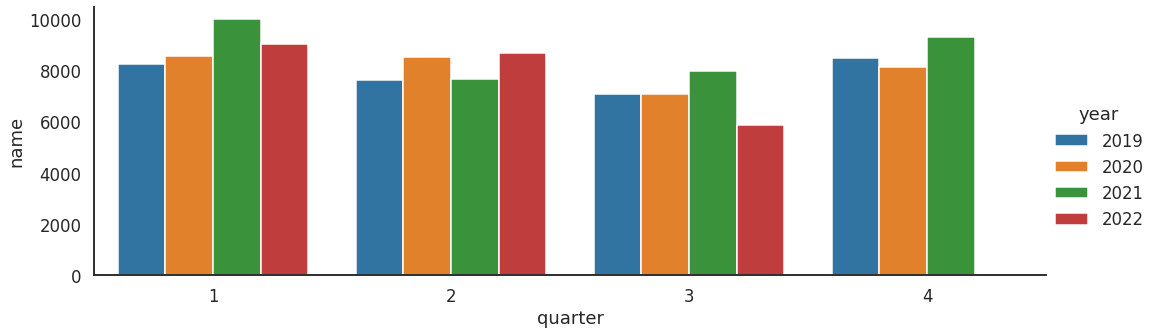

In [1163]:
df['quarter'] = df.date.dt.quarter
g=df.groupby(['year','quarter']).agg({'name':np.size}).reset_index()
g = g[(g.year>2018) & (g.year<2023)]
sns.catplot(data=g,x='quarter',y='name',hue='year',kind='bar',aspect=3.0)
plt.savefig('ireland_deaths_ripie_bymonth_v2.png',dpi=150)

In [150]:
pop = pd.read_csv('ireland_population.csv')

In [32]:
#x=df[(df.month<=12) & (df.month>5)]
totals = df.groupby('year').agg('size')
#print (totals)
'''ax=totals.plot(kind='bar',grid=True,figsize=(10,5))
plt.title('RIP.ie estimate, total deaths per year')
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_ripie_summary_v3.png',dpi=120)'''

"ax=totals.plot(kind='bar',grid=True,figsize=(10,5))\nplt.title('RIP.ie estimate, total deaths per year')\nsns.despine()\nplt.tight_layout()\nplt.savefig('ireland_deaths_ripie_summary_v3.png',dpi=120)"

In [147]:
gro = pd.read_csv('gro_deaths_yearly.csv')

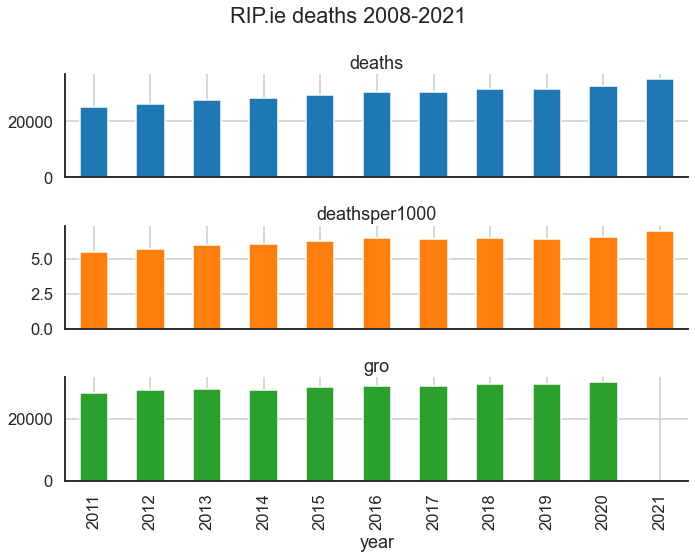

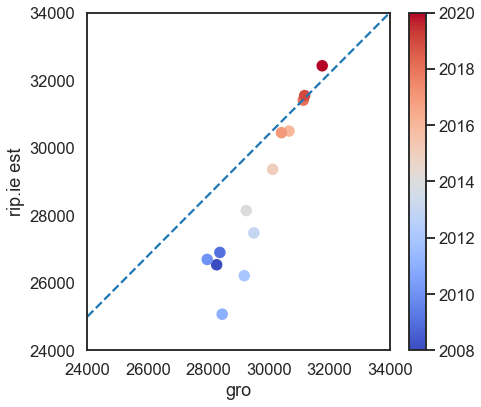

In [34]:
d=pd.DataFrame(totals,columns=['deaths']).reset_index()
d=pop.merge(d,on='year')
d=d.sort_values('year')
d['deathsper1000'] = d.deaths/d['pop']*1e3
d=d.merge(gro,on='year',how='left')
d['diff'] = d.deaths-d.gro
d[3:].plot(x='year',y=['deaths','deathsper1000','gro'],kind='bar',subplots=True,grid=True,legend=False,figsize=(10,8))
plt.suptitle('RIP.ie deaths 2008-2021')
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_ripie_summary_v3.png',dpi=120)

fig,ax=plt.subplots(1,1,figsize=(7,6))
d.plot('gro','deaths',kind='scatter',c=d.year,s=100,cmap='coolwarm',ax=ax)
ax.set_ylabel('rip.ie est')
ax.plot([24000, 34000], [25000, 34000], ls='--')
ax.set_xlim(24000,34000)
ax.set_ylim(24000,34000)
plt.tight_layout()
fig.savefig('ireland_deaths_gro_vs_ripie2.png',dpi=120)

In [ ]:
byw = pd.pivot_table(df, index='week',columns='year',values='name',aggfunc='size')
byw['5 yr average'] = byw.iloc[:,8:-1].mean(1)
x=byw.iloc[23:52,13:]
#print (x)
x.plot(kind='bar',width=.8,figsize=(20,6))
#x.T.boxplot(figsize=(18,6))
plt.legend(loc=4,ncol=5,framealpha=0.9,fontsize=20)
plt.suptitle('RIP.ie deaths per week 2021')
sns.despine()
#plt.savefig('ireland_deaths_ripie_byweek.png',dpi=150)

## smoothed trends per year

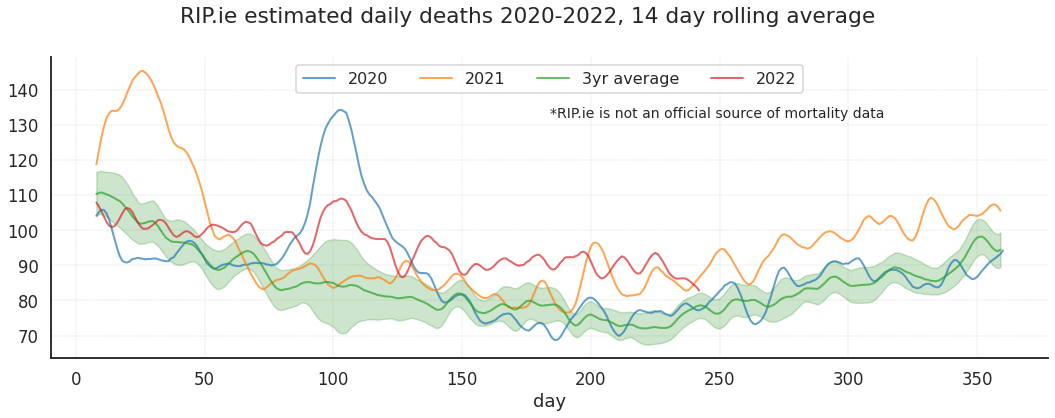

In [1164]:
def plot_average_trend(df, title=''):
    
    byday = pd.pivot_table(df, index='day',columns='year',values='name',aggfunc='size')
    #print (byday.iloc[:,9:-3])
    byday['3yr average'] = byday.iloc[:,9:-3].mean(1)
    byday['sd'] = byday.iloc[:,9:-3].std(1)
    x = byday[[2020,2021,'3yr average',2022]]
    #x = x.loc[:50]
    #sd=sd[:50]
    #x.loc[364:,2021] = np.nan
    win=14
    meanday = x.rolling(window=win,win_type='hamming',center=True).mean()
    sd = byday['sd'].rolling(window=win,win_type='hamming',center=True).mean()
    ax=meanday.plot(figsize=(15,6),lw=2,alpha=0.7)
    ave=meanday['3yr average']
    
    ax.fill_between(ave.index, ave-(sd/2), ave+(sd/2), color='green', alpha=0.2)
    ax.grid(linestyle='--',linewidth=.4)
    plt.legend(loc=9,ncol=4,fontsize=16)
    sns.despine()
    plt.suptitle('%s, %s day rolling average' %(title,win))
    plt.tight_layout()
    plt.text(0.5,0.8,'*RIP.ie is not an official source of mortality data',fontsize=14,transform=ax.transAxes)
    
plot_average_trend(df,'RIP.ie estimated daily deaths 2020-2022')
plt.savefig('ireland_deaths_ripie_compared_mean_v3.png',dpi=150)

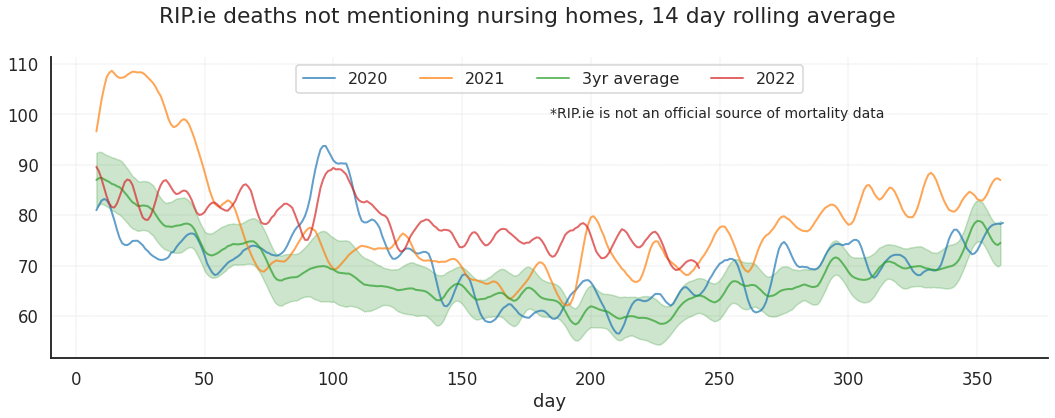

In [1165]:
s=df[df.home.isnull()]   
plot_average_trend(s,'RIP.ie deaths not mentioning nursing homes')
plt.savefig('ireland_deaths_ripie_compared_mean_nursing_homes.png',dpi=150)

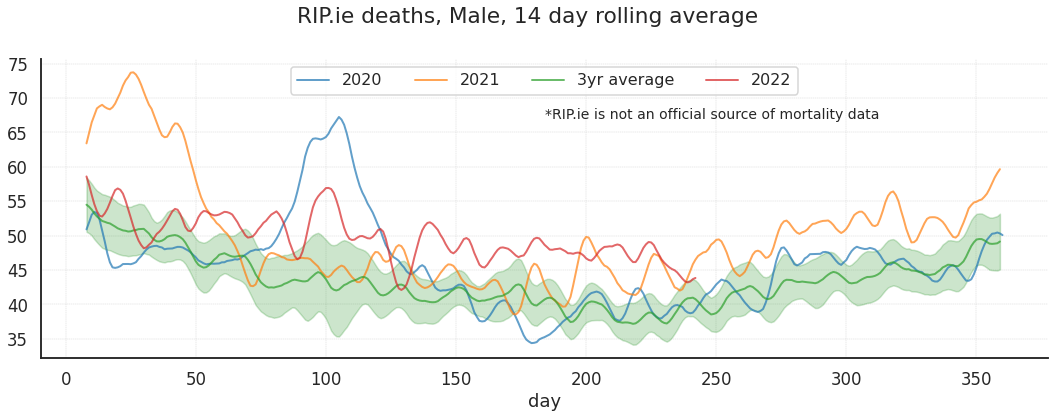

In [849]:
s=df[df.sex=='M']   
plot_average_trend(s,'RIP.ie deaths, Male')

## excess deaths

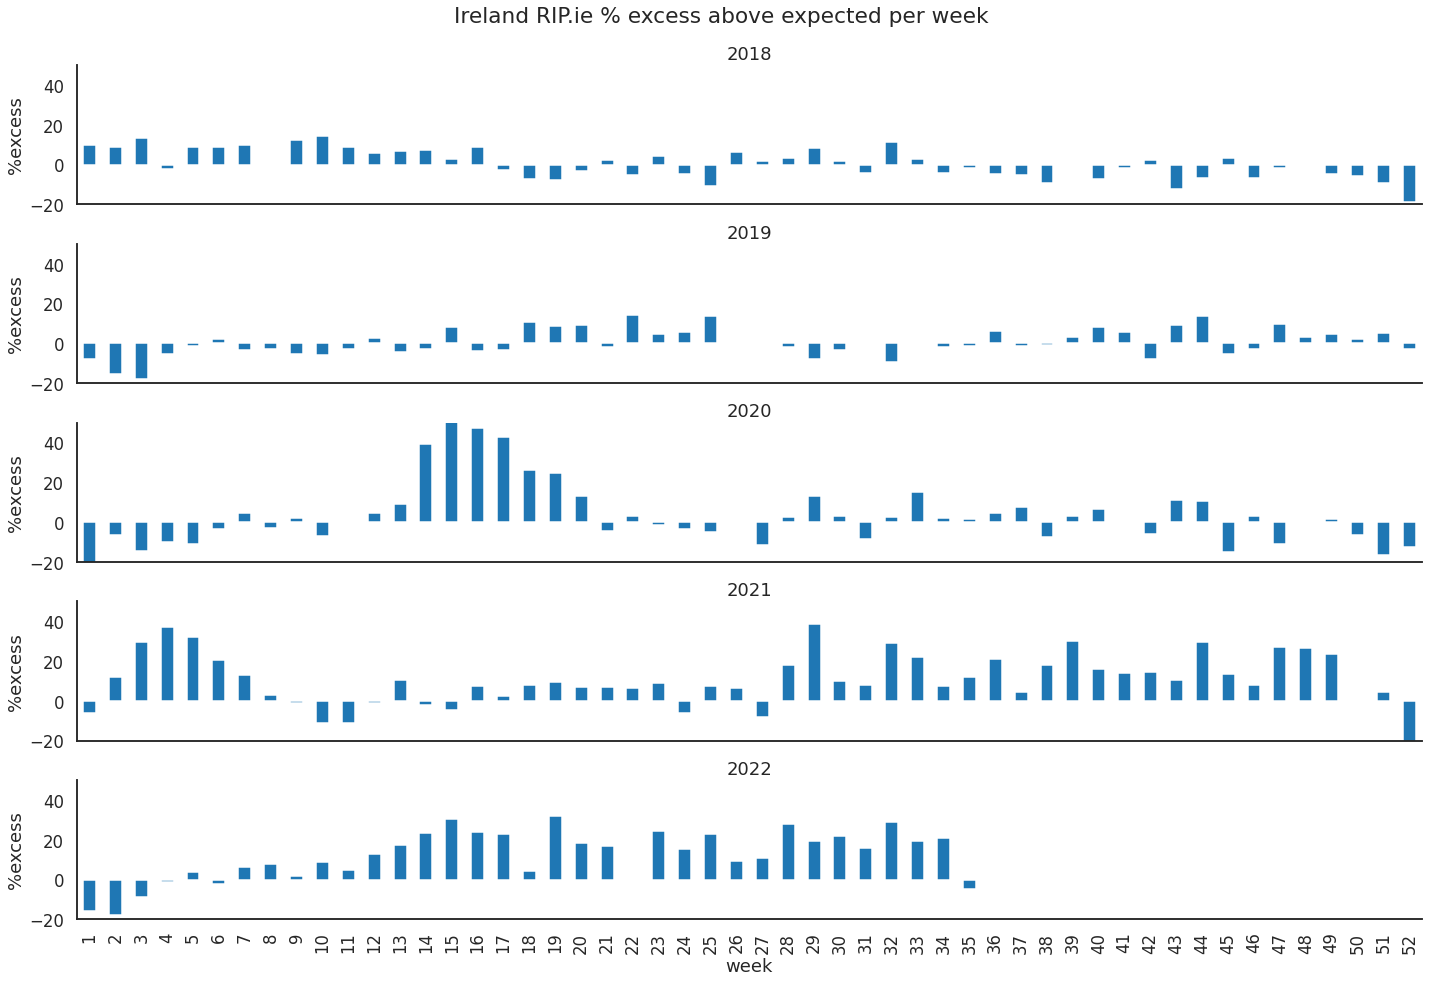

In [1166]:
fig, ax = plt.subplots(5,1,figsize=(20,14))
axs=ax.flat
sub = df[df.sex=='F']   
sub = sub[(sub.date<'2022-09-05')]
g = sub.groupby(['year','week']).agg({'name':np.size}).reset_index()
p = pd.pivot_table(g,index='week',columns='year',values='name',aggfunc='sum')
p['mean'] = p.iloc[:,9:12].mean(1)
p = p.iloc[:-1]
p.loc[52,2022] = None
i=0
exc = p.sub(p['mean'], axis=0)
for year in [2018,2019,2020,2021,2022]:
    ax=axs[i]
    #p['excess'] = p[year]-p['mean']
    p['excess'] = (p[year]-p['mean'])/p['mean']*100
    p.plot(y=['excess'],kind='bar',stacked=True,legend=False,ax=ax)
    ax.set_ylabel('%excess')
    ax.set_title(year)
    ax.set_ylim(-20,50)
    if i<4:
        ax.set_xticklabels([])
        ax.set_xlabel('')
    i+=1
fig.suptitle('Ireland RIP.ie % excess above expected per week')
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_weekly_excess_percentage.png',dpi=130)

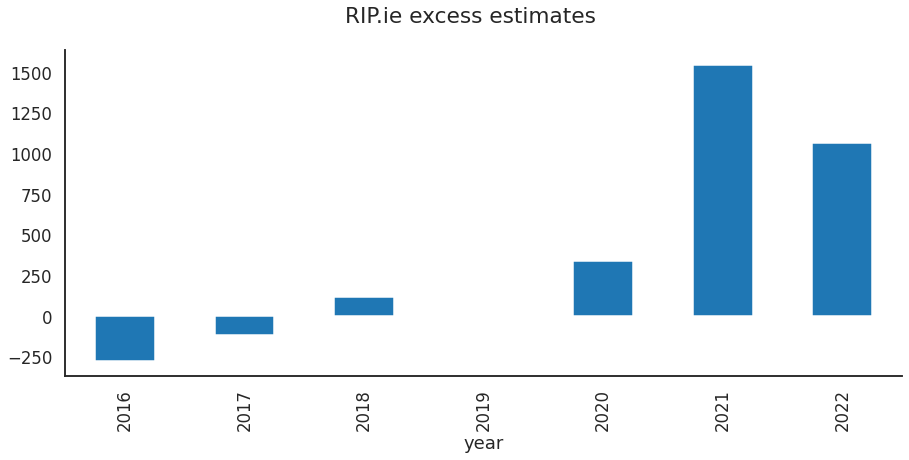

In [1167]:
fig, ax = plt.subplots(1,1,figsize=(15,6))
x=exc.sum()[8:-1]
x.plot(kind='bar',ax=ax)
mean = x.mean()
#print (x)
#ax.hlines(mean,mean,-1,color='r')
fig.suptitle('RIP.ie excess estimates')
sns.despine()

In [1117]:
#sub = df
sub = df[df.home.isnull()] 
sub = sub[sub.year>=2015]
x = sub.groupby('date').size()
r14 = x.rolling(14,win_type='hamming',center=True).mean().dropna()
m22 = x.rolling(200,win_type='hamming',center=True).mean()

#baseline deaths from summer periods only
summer = sub[(sub.month>5) & (sub.month<9)& (sub.year<=2020)]
x = summer.groupby('date').size()
base = x.rolling(14,win_type='hamming',center=True).mean().dropna()

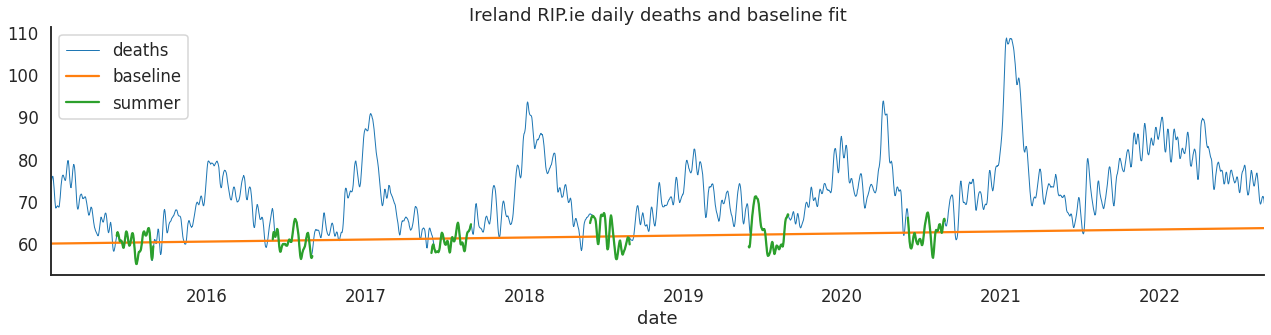

In [1118]:
import statsmodels.formula.api as smf

#rdf=pd.DataFrame([r14,base],columns=['deaths','baseline']).reset_index()
rdf = pd.concat([r14,base],axis=1)
rdf.columns=['deaths','summer']
rdf=rdf.reset_index()
rdf['ind'] = rdf.index.astype(float)+1
rdf['year'] = rdf.date.dt.year
rdf['month'] = rdf.date.dt.month
rdf['day'] = rdf.date.dt.dayofyear
#rdf['rolling'] = rdf.deaths.rolling(window=21,win_type='hamming',center=True).mean()
rdf['season'] = rdf.apply(get_season,1)
#print (rdf)
model = smf.ols(formula='summer ~ ind', data=rdf).fit()

rdf['baseline'] = model.predict(rdf.ind)
rdf['excess'] = rdf.deaths - rdf.baseline

ax=rdf.plot(x='date',y='deaths',lw=1,figsize=(18,5))
rdf.plot(x='date',y='baseline',ax=ax)
rdf.plot(x='date',y='summer',ax=ax)

#rdf.plot(x='date',y='rolling',ax=ax)
plt.title('Ireland RIP.ie daily deaths and baseline fit')
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_baseline_fit.png',dpi=130)

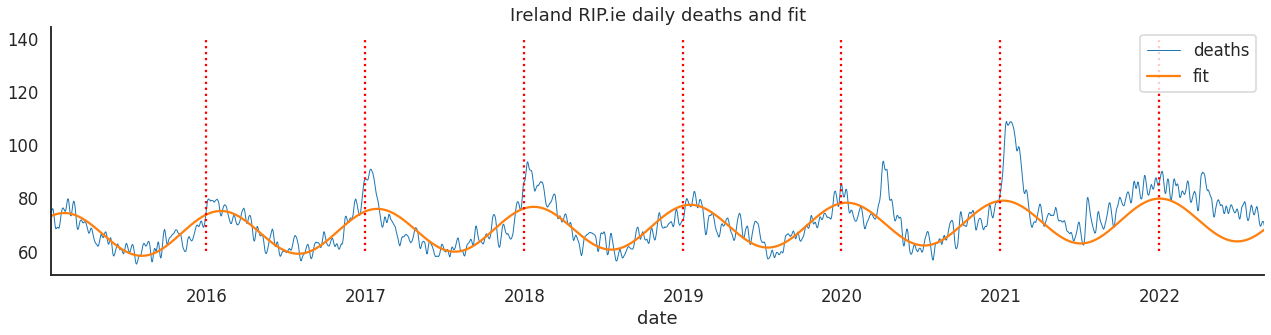

In [1119]:
#import math
pre = rdf[rdf.year<2020]
model2 = smf.ols(formula='deaths ~ ind + np.cos(np.radians(ind)) + np.sin(np.radians(ind))', data=pre).fit()
#model2 = smf.ols(formula='summer ~ ind + np.vander(ind, 2, increasing=True) + 1', data=pre).fit()  

rdf['fit'] = model2.predict(rdf.ind)
rdf['excess2'] = rdf.deaths - rdf.fit

ax=rdf.plot(x='date',y='deaths',lw=1,figsize=(18,5))
rdf.plot(x='date',y='fit',ax=ax)

for y in range(2014,2023):
    ax.vlines(pd.to_datetime('%s-12-31' %y),60,140,color='r',ls=':')
plt.title('Ireland RIP.ie daily deaths and fit')
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_periodic_fit.png',dpi=130)

In [1120]:
rdf['cumexcess'] = rdf.groupby(['year'])['excess2'].cumsum()
#sns.lineplot(data=rdf,x='day',y='year',hue='season',palette='Set2')

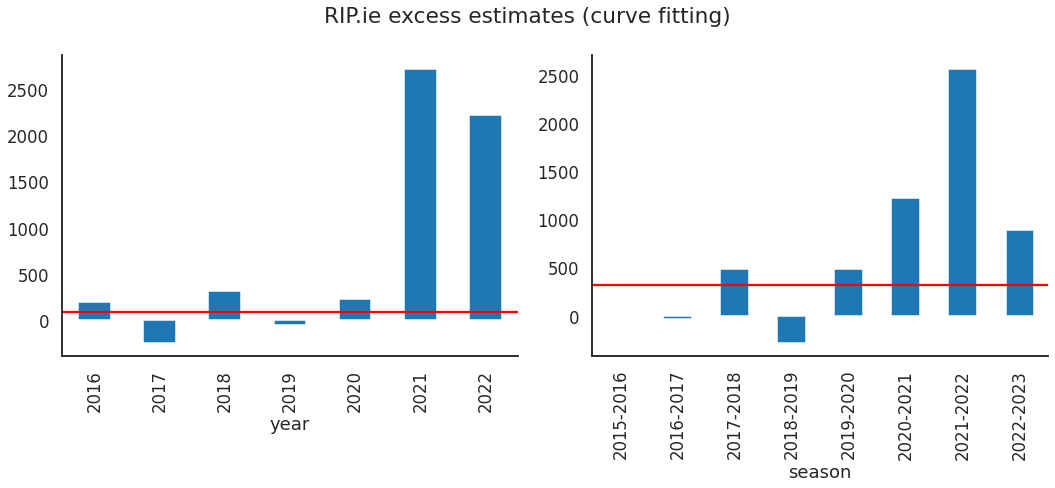

In [1121]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
axs=ax.flat
i=0
for c in ['year','season']:
    ax=axs[i]
    ex = rdf.groupby([c]).agg({'excess2':sum})[1:]
    ex.plot(kind='bar',legend=False,ax=ax)
    mean = ex[:-2].mean()
    std = ex[:-2].std()
    ax.hlines(mean,mean,-1,color='r')
    i+=1
#ax.axhspan(mean-std,mean+std, alpha=0.5, color='red')
fig.suptitle('RIP.ie excess estimates (curve fitting)')
plt.tight_layout()
sns.despine()

In [1123]:
m=ex[:-1]
(ex-mean)/std

,excess2
season,
2015-2016,-0.562415
2016-2017,-0.645092
2017-2018,0.310309
2018-2019,-1.103461
2019-2020,0.310290
2020-2021,1.690369
2021-2022,4.172835
2022-2023,1.059428


## GRO compare

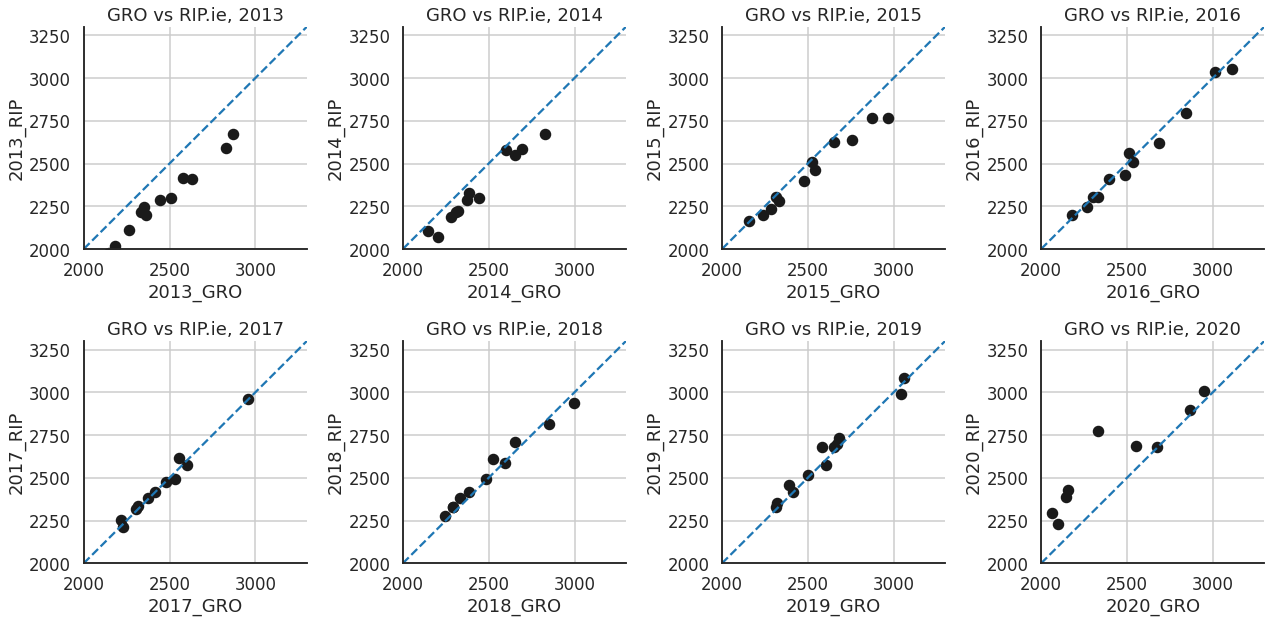

In [21]:
gro = pd.read_csv('gro_deaths.csv')
bymonth = pd.pivot_table(df, index='month',columns='year',values='name',aggfunc='size')
a=bymonth.reset_index()
a.columns=[str(i) for i in a.columns]
b=gro.merge(a,on='month',suffixes=['_GRO','_RIP'])
#print (b)
f,axs=plt.subplots(2,4,figsize=(18,9))
axs=axs.flat
i=0
for y in range(2013,2021):
    ax=axs[i]
    b.plot(x='%s_GRO' %y,y='%s_RIP' %y,c='0.1',s=100,kind='scatter',grid=True,ax=ax)
    ax.plot([2000, 3300], [2000, 3300], ls='--')
    ax.set_xlim(2000,3300)
    ax.set_ylim(2000,3300)
    ax.set_title('GRO vs RIP.ie, %s' %y)
    i+=1
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_gro_vs_ripie.png',dpi=150)

## compare eurostat data

In [ ]:
eu=pd.read_csv('estat_demo_r_mwk_ts_filtered.tsv',sep='\t').T
eu.columns=['Eurostat']

In [ ]:
x = df.groupby(['year','week']).size().reset_index()
x['time'] = x.apply(lambda x: '%s-W%02d' %(x.year,x.week),1)
x=x.set_index('time').iloc[:,2:]
x.columns=['RIP.ie']
#print (x[-20:])
x=x.merge(eu,left_index=True, right_index=True,how='right')
#x['diff'] = x.RIP-x.Eurostat
#print (x[-20:])
fig,ax=plt.subplots(1,1,figsize=(17,7))
ax=x.plot(lw=3,ax=ax,grid=True)
sns.despine()
plt.tight_layout()
plt.title('Weekly mortality RIP.ie estimate vs Eurostat',fontsize=25)
#ax2 = fig.add_axes( [0.4, 0.6, 0.15, 0.3])
#x.plot(x='Eurostat',y='RIP.ie',kind='scatter',c='black',ax=ax2)
plt.tight_layout()
fig.savefig('eurostat_ireland_deaths_compared.png')

## CSO RIP.ie

CSO's estimates can be accessed via their Pxstat system [here](https://data.cso.ie/product/MFPDA). See also https://www.cso.ie/en/releasesandpublications/in/vs/informationnoteonthepublicationofmortalityfiguresusingpublicdatasources/

In [22]:
cso=pd.read_csv('rip_cso_est.csv')
cso['date'] = pd.to_datetime(cso.Day)

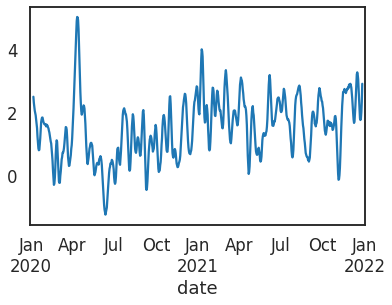

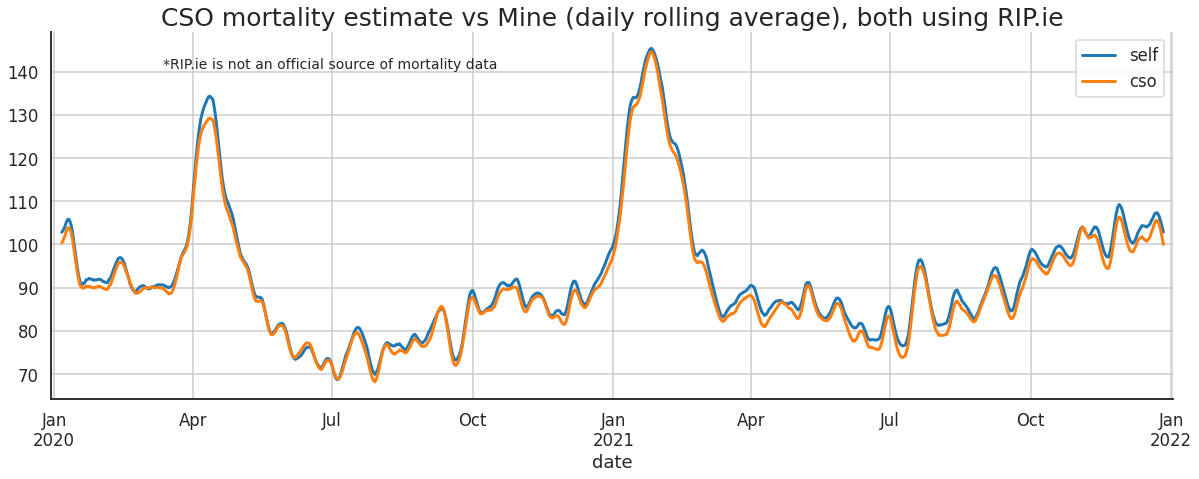

In [23]:
x = pd.DataFrame(df.groupby('date').size(),columns=['deaths']).reset_index()
x=x.merge(cso,on='date',how='right').set_index('date')
x=x[['deaths','VALUE']]
#(x.deaths-x.VALUE).rolling(window=win).mean().plot()
x.columns=['self','cso']
win=14
x=x.rolling(window=win,win_type='hamming',center=True).mean()
diff=x.self-x.cso
diff.plot()
fig,ax=plt.subplots(1,1,figsize=(17,7))
ax=x.plot(lw=3,ax=ax,grid=True)
plt.title('CSO mortality estimate vs Mine (daily rolling average), both using RIP.ie',fontsize=25)
plt.text(0.1,0.9,'*RIP.ie is not an official source of mortality data',fontsize=14,transform=ax.transAxes)
sns.despine()
plt.tight_layout()
fig.savefig('cso_ireland_deaths_compared.png')

In [ ]:
agep=pd.read_csv('EY002.20220127T230103.csv')
agep=agep[(agep.Sex=='Both sexes') &(agep['Age Group']!='All ages')]
agep['total']=agep.groupby('CensusYear')["VALUE"].transform('sum')
agep['ratio']=agep.VALUE/agep.total
agep

In [ ]:
x=df[(df.year==2020) & (df.month==4) & (df.home.notnull())]
x.home.value_counts()

## OWID excess deaths

In [24]:
owid=pd.read_csv('excess-mortality-p-scores-average-baseline.csv')
owid['Date'] = pd.to_datetime(owid.Day)

In [25]:
x = owid[owid.Entity.isin(['Ireland'])]#'United Kingdom','Italy'])]
x = x.merge(rdf,left_on='Date',right_on='date',how='left')
#sns.lineplot(data=x,x='Date',y='p_avg_all_ages',hue='Entity')

NameError: name 'rdf' is not defined

KeyError: "['excess2'] not in index"

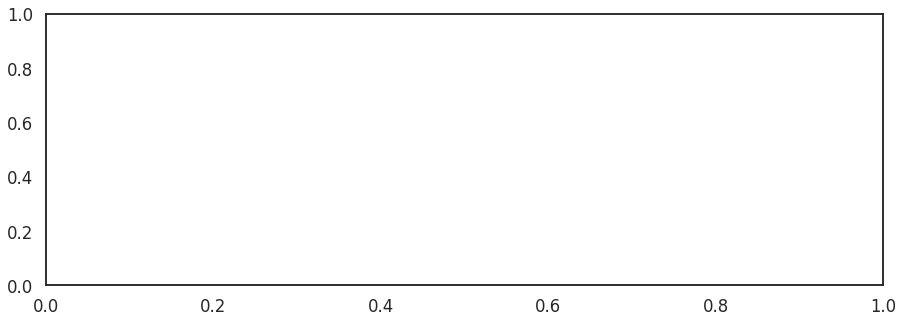

In [26]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
x.plot(x='Date',y=['p_avg_all_ages','excess2'],ax=ax)
ax.legend(labels=['OWID excess','RIP.ie estimate'])
sns.despine()
#axs=x.groupby('Entity').plot(x='Date',y='p_avg_all_ages',subplots=True,layout=(3,1),sharey=True)